In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
def run_QIF(neuron_params, time_params, W, stim):

    # unpack parameters
    tau, tau_s, lam = neuron_params
    T, stim_on, stim_off, dt = time_params
    nloop, train_every = train_params
    
    # tau: neuron decay constant
    # tau_s: synaptic decay constant
    # lam: learning rate
    # T: total training time
    # dt: time step
    # nloop: number of training trials

    # initialize variables
    theta = np.zeros(N) # phase of neurons
    u = np.zeros(N) # synaptic drive
    r = np.zeros(N) # filtered synaptic drive

    # ODE of theta neuron model
    def dtheta(theta, n_drive):
        return 1/tau * (1 - np.cos(theta) + np.multiply(n_drive, (1 + np.cos(theta))))

    # ODE of filtered spike train
    def dr(r): 
        return -1/tau_s * r 
        # does not include addition of new spikes

    # optional variables to track states
    spks = []
    sdrive = []
    thetas = []

    # training loop
    t = 0.0
    itr = 0
    while t < T + 100 - dt:

        # RK4 for theta neuron model (one step)
        if t < stim_off:
            ext = stim[:, int(t/dt)]
        if t > stim_off:
            ext = np.zeros(N)
        
        k1 = dt * dtheta(theta, u + ext);
        k2 = dt * dtheta(theta + k1/2, u + ext);
        k3 = dt * dtheta(theta + k2/2, u + ext);
        k4 = dt * dtheta(theta + k3, u + ext);
        theta_next = theta + (k1 + 2*k2 + 2*k3 + k4)/6;

        # RK4 for filtered spike train (one step)
        r1 = dt * dr(r) 
        r2 = dt * dr(r + r1/2)
        r3 = dt * dr(r + r2/2)
        r4 = dt * dr(r + r3)
        r_next = r + (r1 + 2*r2 + 2*r3 + r4)/6

        # spike detection
        idx1 = theta_next - theta > 0
        idx2 = theta_next - theta > np.mod(np.pi - theta, 2*np.pi) # surely there's a better way to do this...
        idx = np.multiply(idx1, idx2)
        r[idx] += 1/tau_s # update spikes in r

        # update variables
        theta = np.mod(theta + (k1 + 2*k2 + 2*k3 + k4)/6, 2*np.pi)
        r = r + (r1 + 2*r2 + 2*r3 + r4)/6
        u = np.dot(W, r)
        t = t + dt

        # track variables (optional)
        spks.append(r)
        sdrive.append(u)  
        thetas.append(theta)

    spks = np.transpose(spks)
    sdrive = np.transpose(sdrive)
    thetas = np.transpose(thetas)
    return spks, sdrive, thetas

In [341]:
def train_QIF_loop(neuron_params, time_params, train_params, W, stim, targets):

    # unpack parameters
    tau, tau_s, lam = neuron_params
    T, stim_on, stim_off, dt = time_params
    nloop, train_every = train_params
    
    # tau: neuron decay constant
    # tau_s: synaptic decay constant
    # lam: learning rate
    # T: total training time
    # dt: time step
    # nloop: number of training trials

    # initialize variables
    theta = np.zeros((N, 1)) # phase of neurons
    u = np.zeros((N, 1)) # synaptic drive
    r = np.zeros((N, 1)) # filtered synaptic drive

    # initialize correlation matrices for each row
    Pidx = np.zeros((N, N))
    Ps = []
    for row in range(N):
        Pidx[row] = (W[row] != 0)
        tot = int(np.sum(Pidx[row]))
        Ps.append(1/lam * np.identity(tot))
    Pidx = Pidx.astype(bool)

    # ODE of theta neuron model
    def dtheta(theta, n_drive):
        return 1/tau * (1 - np.cos(theta) + n_drive * (1 + np.cos(theta)))

    # ODE of filtered spike train
    def dr(r): 
        return -1/tau_s * r 
        # does not include addition of new spikes

    # optional variables to track states
    spks = []
    sdrive = []
    thetas = []
    
    # training loop
    for i in range(nloop):
        print(i)
        t = 0.0
        itr = 0
        while t < T - dt:

            # RK4 for theta neuron model (one step)
            k1 = dt * dtheta(theta, u + stim[:, :, int(t/dt)]);
            k2 = dt * dtheta(theta + k1/2, u + stim[:, :, int(t/dt)]);
            k3 = dt * dtheta(theta + k2/2, u + stim[:, :, int(t/dt)]);
            k4 = dt * dtheta(theta + k3, u + stim[:, :, int(t/dt)]);
            theta_next = theta + (k1 + 2*k2 + 2*k3 + k4)/6;
            
            # RK4 for filtered spike train (one step)
            r1 = dt * dr(r) 
            r2 = dt * dr(r + r1/2)
            r3 = dt * dr(r + r2/2)
            r4 = dt * dr(r + r3)
            r_next = r + (r1 + 2*r2 + 2*r3 + r4)/6

            # spike detection
            idx1 = theta_next - theta > 0
            idx2 = theta_next - theta > np.mod(np.pi - theta, 2*np.pi)
            #print(idx1)
            #print(idx2)
            idx = idx1 * idx2
            r[idx] += 1/tau_s # update spikes in r

            # update variables
            theta = np.mod(theta + (k1 + 2*k2 + 2*k3 + k4)/6, 2*np.pi)
            r = r + (r1 + 2*r2 + 2*r3 + r4)/6
            u = W @ r
            t = t + dt
            
            # track variables (optional)
            spks.append(r)
            sdrive.append(u)  
            thetas.append(theta)

            # train W matrix
            if t > stim_off and np.mod(int(t/dt), int(train_every/dt)) == 0: # only train after initial stimulus
                #print('training')
                for row in range(N): # update each row of W by RLS

                    # update correlation matrix
                    # print(np.shape(Ps[row]))
                    # print(np.shape(r[Pidx[row]]))
                    Ps[row] = Ps[row] - Ps[row] @ r[Pidx[row]] @ r[Pidx[row]].T @ Ps[row] / (1 + r[Pidx[row]].T @ Ps[row] @ r[Pidx[row]])

                    # update error term
                    err = targets[row][int(t/dt)] - W[row][Pidx[row]] @ r[Pidx[row]] # error is scalar

                    # update W
                    # print(np.shape(Pidx[row]))
                    # print(np.shape(W[row]))
                    # print(np.shape(err * Ps[row] @ r[Pidx[row]]))
                    W[row][Pidx[row]] = W[row][Pidx[row]] + (err * Ps[row] @ r[Pidx[row]])[0]
                    
            if np.max(u) > 10000:
                print("error", t)
                break
                
    spks = np.transpose(spks)
    sdrive = np.transpose(sdrive)
    thetas = np.transpose(thetas)
    return W, spks, sdrive, thetas

In [298]:
P = np.array([[1, 2],[3, 4]])
r = np.array([[1], [2]])

In [336]:
r[:]

array([[1],
       [2]])

In [315]:
P @ r @ r.T @ P

array([[ 35,  50],
       [ 77, 110]])

In [239]:
theta = np.zeros((3, 1))
n_drive = np.array([[1], [2], [3]])

In [162]:
1/tau * (1 - np.cos(theta) + n_drive * (1 + np.cos(theta)))

array([[2.],
       [4.],
       [6.]])

In [254]:
# returns a sparse NxN matrix with gaussian entries
def genw_sparse_fig1(N, m, std, p):
    weight = sp.stats.norm.rvs(m, std, (N, N))
    is_zero = np.random.choice([0, 1], (N, N), [1-p, p]) 
    W = np.multiply(weight, is_zero)
    for row in W: 
        row = row - np.mean(row)
    return np.multiply(weight, is_zero)

In [273]:
def gen_stim_fig1(N, timesteps):
    stim = np.zeros((N, 1, timesteps))
    for row in range(N):
        rstim = 2 * sp.stats.uniform.rvs(0, 1) - 1 # random stim weight from -1, 1
        # use shape in future
        stim[row, :, :] = rstim
    return stim

In [267]:
def gen_sine_fig1(N, timesteps): 
    targets = np.zeros((N, timesteps))
    for i in range(N):
        amp = sp.stats.uniform.rvs() + 1
        t0 = sp.stats.uniform.rvs() * 1000
        t1 = sp.stats.uniform.rvs() * 700 + 300
        x = np.arange(timesteps)/10
        targets[i] = amp * np.sin(2*np.pi*(x - t0)/t1)
    return targets

# training

In [338]:
# parameters
# matches parameters in figure supplement 1
N = 200
m = 0
std = 1
p = 0.3

T = 1000 # ms 
stim_on = 0 # ms
stim_off = 50 # ms
dt = 0.1 # ms
nloop = 10
train_every = 2 # ms

timesteps = int(T/dt) # unitless, total number of timesteps

tau = 1 # ms, neuron phase decay constant
tau_s = 20 # ms, spike train decay constant 
lam = 1 # learning rate constant

neuron_params = tau, tau_s, lam
time_params = T, stim_on, stim_off, dt
train_params = nloop, train_every

In [339]:
W = genw_sparse_fig1(N, m, std/np.sqrt(N*p), p)
W_trained = np.copy(W)
stim = gen_stim_fig1(N, timesteps)
targets = gen_sine_fig1(N, timesteps) # 2 is maximum number of cycles in training period

In [342]:
W_trained, spks, sdrive, thetas = train_QIF_loop(neuron_params, time_params, train_params, W_trained, stim, targets)

0
error 6.199999999999994
1
error 0.1
2
error 0.1
3
error 0.1
4
error 0.1
5
error 0.1
6
error 0.1
7
error 0.1
8
error 0.1
9
error 0.1


(-1.2636959750955348+0.3641726969107636j)

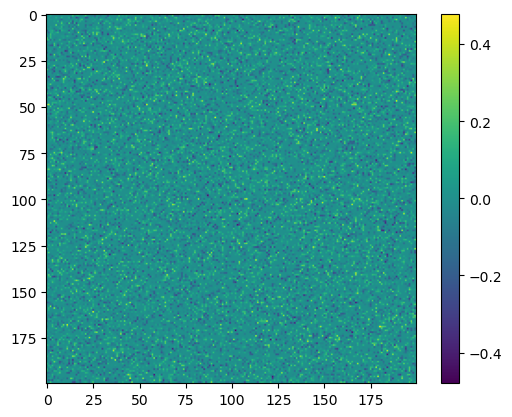

In [343]:
plt.imshow(W)
plt.colorbar()
np.linalg.eig(W)[0][0]

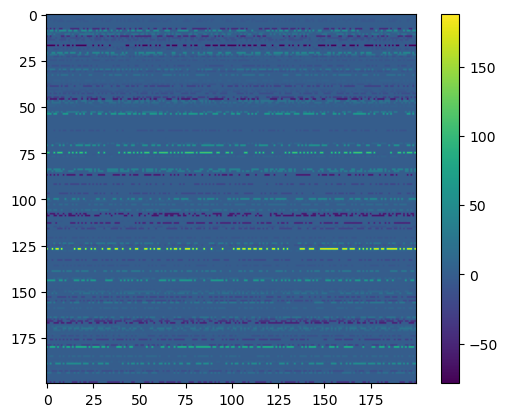

In [344]:
plt.imshow(W_trained)
plt.colorbar()

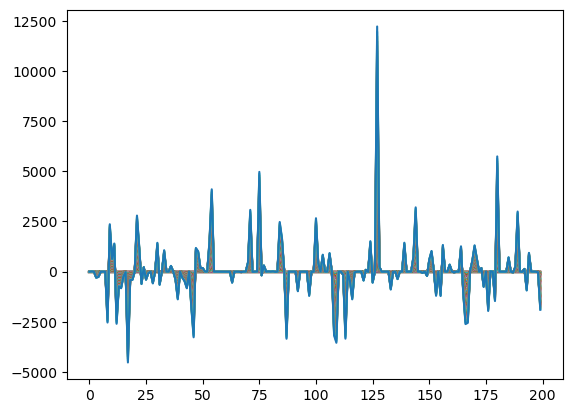

In [345]:
plt.plot(sdrive[0])

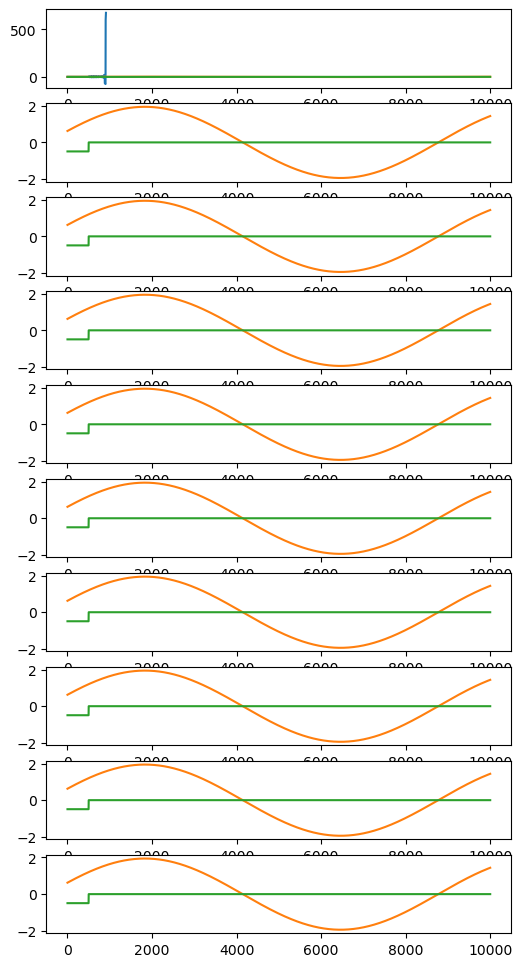

In [21]:
ind = 0

fig, axs = plt.subplots(nloop, 1, figsize = (6, 12))
for i in range(nloop):
    axs[i].plot(sdrive[ind][i*int(T/dt):(i+1)*int(T/dt)])
    axs[i].plot(targets[ind])
    axs[i].plot(stim[ind])

# run network

In [22]:
spks_t, sdrive_t, thetas_t = run_QIF(neuron_params, time_params, W_trained, stim)

NameError: name 'sdrive_t' is not defined

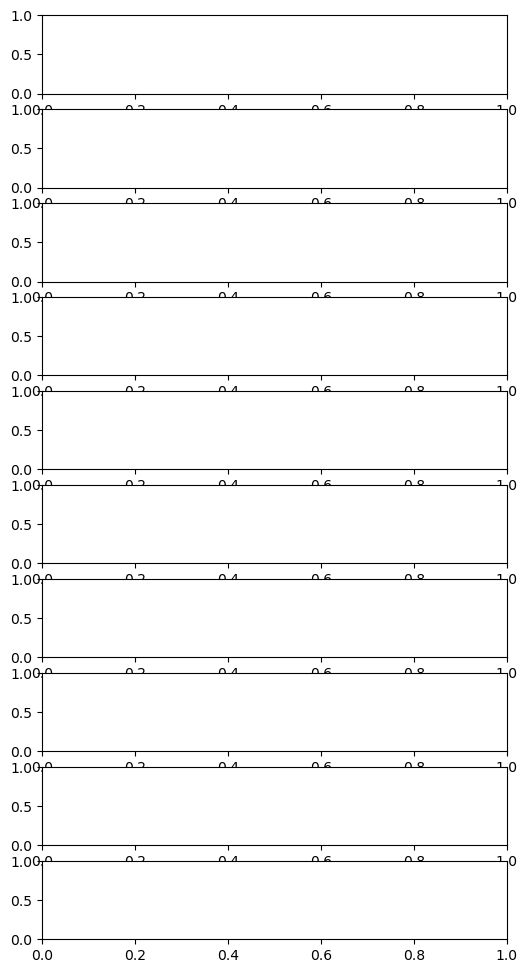

In [13]:
n_plot = 10

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12))
for i in range(n_plot):
    axs[i].plot(sdrive_t[i])
    axs[i].plot(targets[i])
    axs[i].plot(stim[i])